# Noise Reduction 

***
***

## Import Modules

In [16]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.reset()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
import importlib
import Arduino_NoiseReduction_Code as NR

In [18]:
importlib.reload(NR)

<module 'Arduino_NoiseReduction_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\Arduino_NoiseReduction_Code.py'>

## Fit Functions

In [19]:
####### LINEAR FUCTION
def lin(x, a, b):  
    return a + b * x

####### EXPONENTIAL FUCTION
def esp(x, a, b, c):  
    return a + b * np.exp(- x * c**-1)

## Arduino Calibration

### Choose the right calibration function:

Since the signal we are going to acquire with Arduino has an amplitude between 300mV and 400mV we choose not to consider high tension inputs for the calibration. Higher tension inputs have a totally different trend: we will use them (and only them) if we find an high tension signal to acquire.

In [20]:
# READ DATA
data_low = NR.arduino_calib_read_low()

# ERROR PROPAGATION
data_low['err Vin'] = NR.propagazione_cursori(data_low['Vdiv'], data_low['Vin'])

NR.arduino_calibration(data_low)

VOLT =  (-0.633 +/- 0.015)  +  (0.000824 +/- 0.000013)  ADC


## Check the Waveform acquired

In [21]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = NR.arduino_calib_offset + NR.arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(NR.arduino_calib_offset_err**2 + data['ADC']**2 * NR.arduino_calib_slope_err**2)

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

# PRINT DATA
data

,time,ADC,time (ms),V (V),err V (V)
1,1,795,0.001047,0.022105,0.017875
2,2,793,0.002094,0.020457,0.017861
3,3,793,0.003141,0.020457,0.017861
4,4,798,0.004188,0.024577,0.017897
5,5,795,0.005236,0.022105,0.017875
...,...,...,...,...,...
2043,2043,793,2.139267,0.020457,0.017861
2044,2044,776,2.140314,0.006450,0.017741
2045,2045,787,2.141361,0.015514,0.017819
2046,2046,788,2.142408,0.016337,0.017826


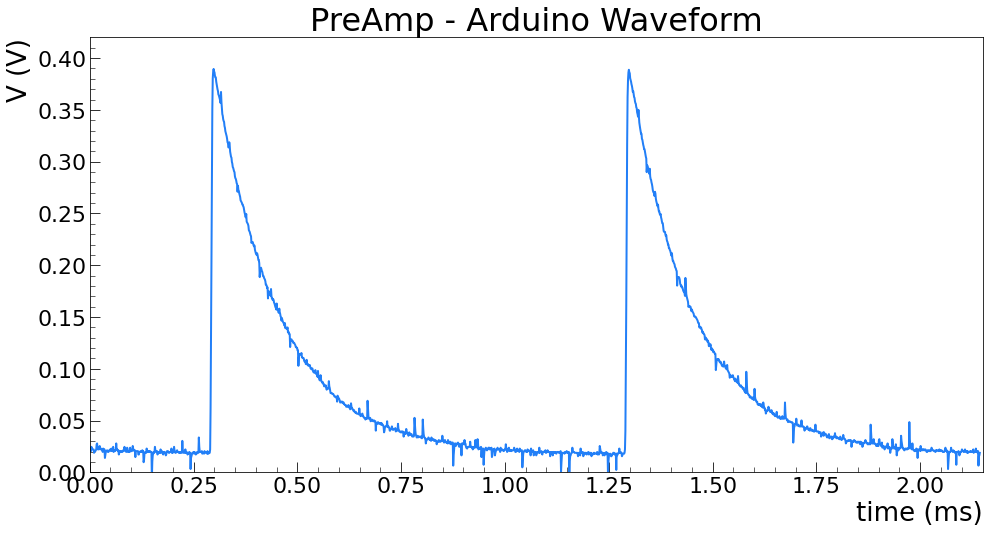

In [22]:
# PLOT DATA
NR.arduino_waveform(data)

As we can see data is a bit noisy, especially the lower tension range between 0 and 100mV

## Noise Reduction: 1st attempt

### Apply an IIR filter to data

In [23]:
import scipy.signal as signal

Here we set up the IIR filter by choosing manually the parameters:

* _b_ will be the numerator coefficient
* _a_ will be the denominator coefficient
* _n_ will be a parameter that determines the overall smoothness of the curve

In [24]:
# we take a quite small n as for higher n values 
# we get a strong deviation from the initial data points
# = not good
n = 5  
b = [1.0 / n] * n
a = 1

# we apply the filter to data
data_IRR = data
data['V filter'] = signal.lfilter(b, a, data['V (V)'])

data_IRR

,time,ADC,time (ms),V (V),err V (V),V filter
1,1,795,0.001047,0.022105,0.017875,0.004421
2,2,793,0.002094,0.020457,0.017861,0.008512
3,3,793,0.003141,0.020457,0.017861,0.012604
4,4,798,0.004188,0.024577,0.017897,0.017519
5,5,795,0.005236,0.022105,0.017875,0.021940
...,...,...,...,...,...,...
2043,2043,793,2.139267,0.020457,0.017861,0.019963
2044,2044,776,2.140314,0.006450,0.017741,0.017161
2045,2045,787,2.141361,0.015514,0.017819,0.016337
2046,2046,788,2.142408,0.016337,0.017826,0.015514


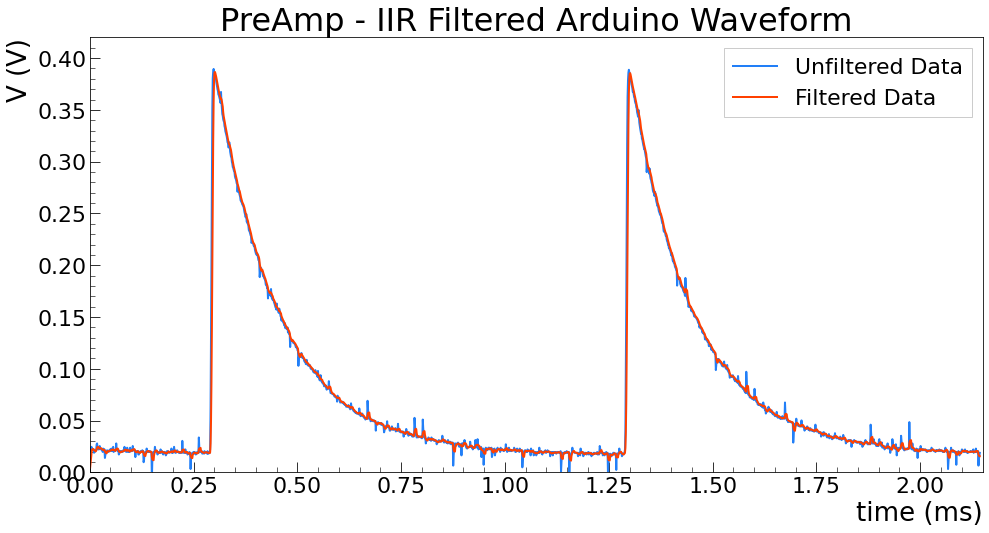

In [25]:
NR.arduino_waveform_IIR_filter(data_IRR)

So far so good. Let's take a closer look at the first peek.

In [26]:
# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek_IIR = data.loc[(data_IRR['time (ms)'] > 0.3) & (data_IRR['time'] < 1200 )]

data_peek_IIR

,time,ADC,time (ms),V (V),err V (V),V filter
287,287,1237,0.300524,0.386283,0.021516,0.386118
288,288,1233,0.301571,0.382987,0.021480,0.386612
289,289,1231,0.302618,0.381339,0.021461,0.385459
290,290,1231,0.303665,0.381339,0.021461,0.383811
291,291,1226,0.304712,0.377220,0.021416,0.381834
...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017161,0.017833,0.011723
1196,1196,789,1.252356,0.017161,0.017833,0.011394
1197,1197,790,1.253403,0.017985,0.017840,0.015514
1198,1198,789,1.254450,0.017161,0.017833,0.016997


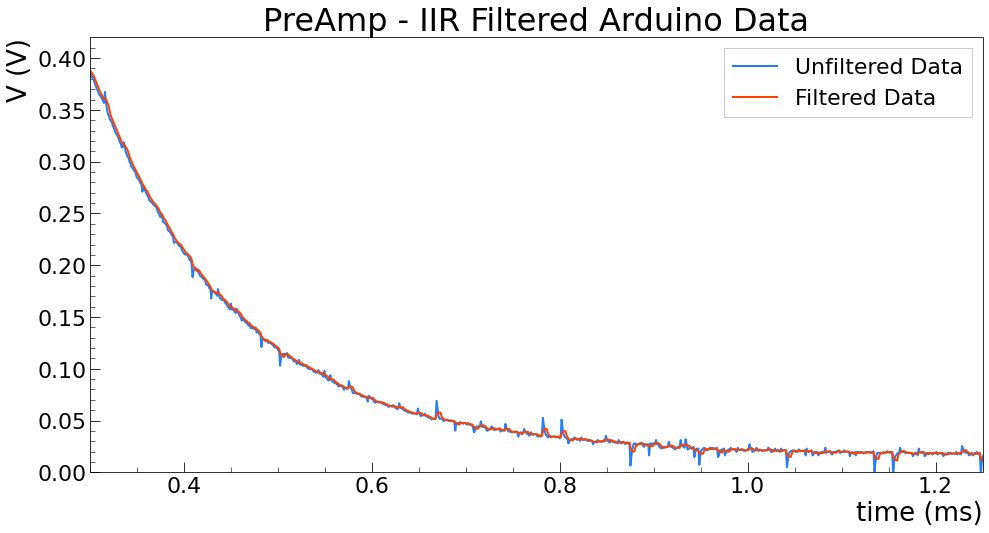

In [27]:
NR.arduino_waveform_IIR_filter_peek(data_peek_IIR)

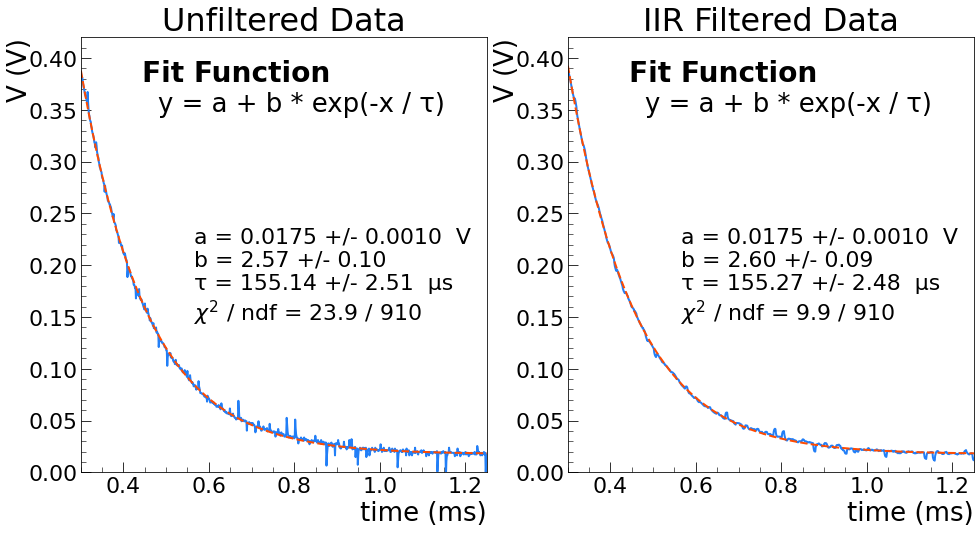

In [28]:
NR.arduino_IIR_exp_fit(data_peek_IIR)

Great results! Data still looks kind of noisy though: let's see if we can do better!

## Noise Reduction: 2nd attempt

### Apply a Butterworth filter to data

I'd like to use a moving average filter but, as it is technically a low-pass filter, it is just easier to apply a low pass filter.

In [29]:
# Desing the Butterworth filter
N  = 3    # Filter order
Wn = 0.1  # Cutoff frequency (normalized)
B, A = signal.butter(N, Wn, output = 'ba')

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek_butter = data_peek

# WE APPLY THE FILTER JUST TO THE FIRST PEEK FOR BETTER RESULTS
data_peek_butter['V filter2'] = signal.filtfilt(B, A, data_peek_butter['V (V)'])

data_peek_butter

,time,ADC,time (ms),V (V),err V (V),V filter2
287,287,1237,0.300524,0.386283,0.021516,0.386188
288,288,1233,0.301571,0.382987,0.021480,0.383781
289,289,1231,0.302618,0.381339,0.021461,0.381426
290,290,1231,0.303665,0.381339,0.021461,0.379136
291,291,1226,0.304712,0.377220,0.021416,0.376921
...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017161,0.017833,0.014329
1196,1196,789,1.252356,0.017161,0.017833,0.014483
1197,1197,790,1.253403,0.017985,0.017840,0.014704
1198,1198,789,1.254450,0.017161,0.017833,0.014974


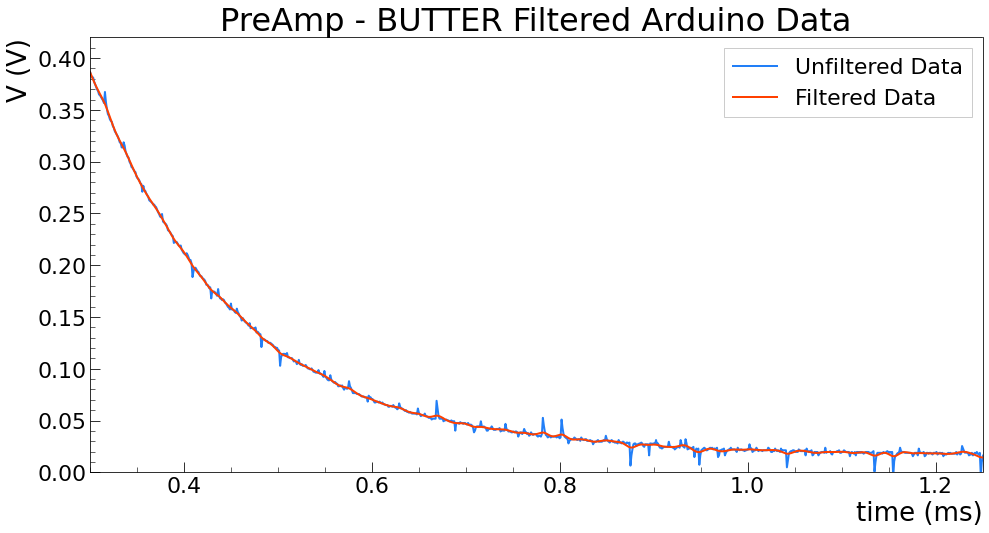

In [30]:
NR.arduino_waveform_BUTTER_filter_peek(data_peek_butter)

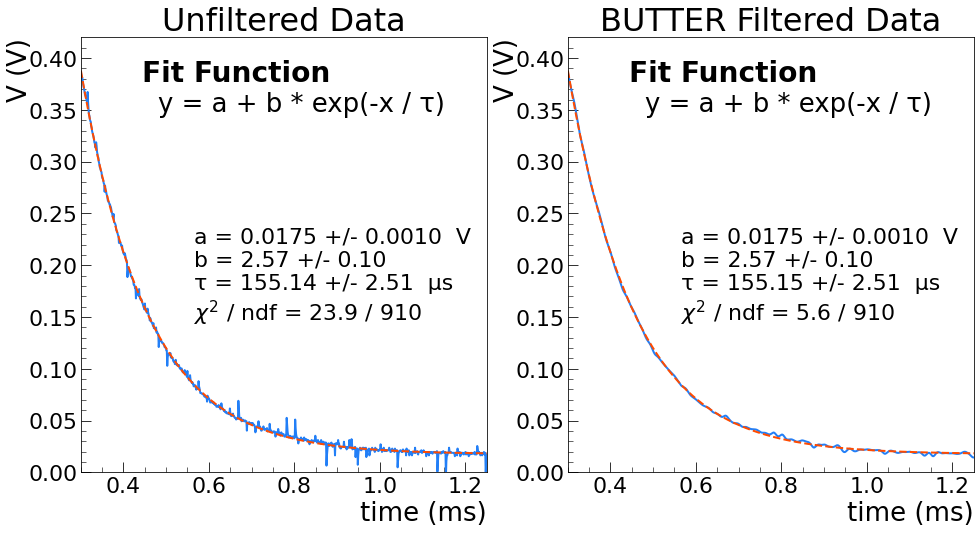

In [31]:
NR.arduino_BUTTER_exp_fit(data_peek_butter)

As we can see, the fit gets really better now! Data is way less noisy than before. 

## Linearized Fit

The main reason we want a noise-clear data is linearization: noisy data is, in fact, way harder to linearize. Here an example of unfiltered linearized data:

In [33]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = NR.arduino_calib_offset + NR.arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(NR.arduino_calib_offset_err**2)

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

In [34]:
# Normalize data by subtracting the exponential fit offset a 
data_linearized = data_peek
data_linearized['normV'] = data_linearized['V (V)'] - NR.unfiltered_exp_offset

# Drop all negative values
data_linearized = data_linearized[(data_linearized['normV'] > 0)]

# Error propagation on the difference
data_linearized['err normV'] = np.sqrt(data_linearized['err V (V)']**2 + NR.unfiltered_exp_offset_err**2)

# Take the natural logarithm 
data_linearized['logV'] = np.log(data_linearized['normV'])

# Error propagation on the logarithm
data_linearized['err logV'] = data_linearized['err normV'] / data_linearized['normV']

# Drop data with huge uncertainty as it is not significative 
data_linearized = data_linearized[(data_linearized['err logV'] < 1)]

data_linearized.drop(['normV', 'err normV'], axis=1, inplace = True)
data_linearized

,time,ADC,time (ms),V (V),err V (V),logV,err logV
287,287,1237,0.300524,0.386283,0.014785,-0.997612,0.040182
288,288,1233,0.301571,0.382987,0.014785,-1.006590,0.040545
289,289,1231,0.302618,0.381339,0.014785,-1.011109,0.040728
290,290,1231,0.303665,0.381339,0.014785,-1.011109,0.040728
291,291,1226,0.304712,0.377220,0.014785,-1.022497,0.041195
...,...,...,...,...,...,...,...
772,772,808,0.808377,0.032816,0.014785,-4.180415,0.968970
779,779,809,0.815707,0.033640,0.014785,-4.127937,0.919431
780,780,808,0.816754,0.032816,0.014785,-4.180415,0.968970
786,786,809,0.823037,0.033640,0.014785,-4.127937,0.919431


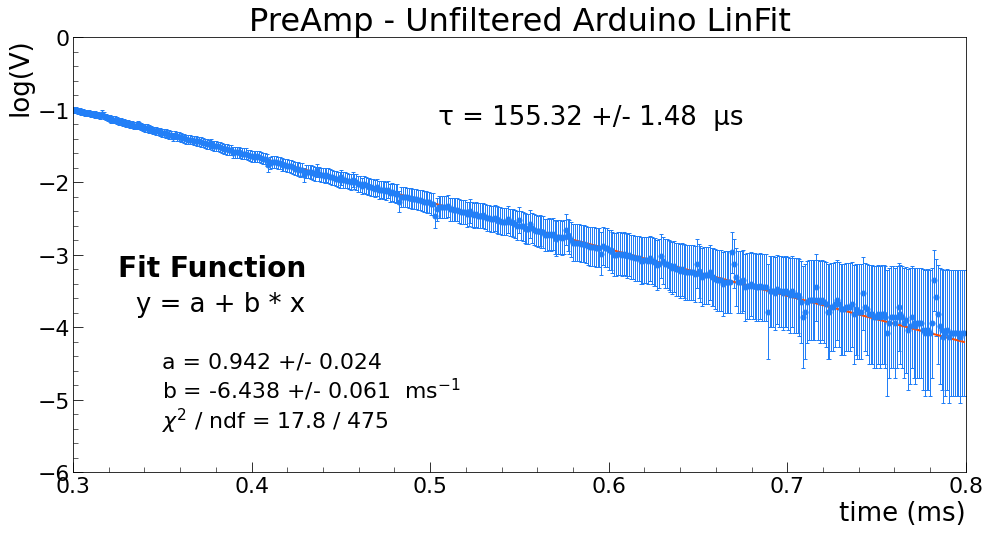

In [35]:
NR.arduino_lin_fit(data_linearized)

Even though the results are not _that_ bad, the fit does not satisfy _that_ much. Let's point out that most of the data points have been removed due to **huge** uncertainty: normalizing data with the offset of the exponential fit leads most of the tail-data really close to zero. The error propagation on the logarithm of such points results in a exaggerated uncertainty. Moreover, the noise is hard to normalize thus we still have a non-linear tail!

### Linearized Butterworth Filter

In [638]:
# Normalize data by subtracting the exponential fit offset a 
data_peek_butter['normV filter'] = data_peek_butter['V filter2'] - NR.butter_exp_offset

# Drop all negative values
data_peek_butter = data_peek_butter[(data_peek_butter['normV filter'] > 0)]

# Error propagation on the difference
data_peek_butter['err normV filter'] = np.sqrt(data_peek_butter['err V (V)']**2 + NR.butter_exp_offset_err**2)

# Take the natural logarithm 
data_peek_butter['logV filter'] = np.log(data_peek_butter['normV filter'])

# Error propagation on the logarithm
data_peek_butter['err logV filter'] = data_peek_butter['err normV filter'] / data_peek_butter['normV filter']

# Drop data with huge uncertainty as it is not significative 
data_peek_butter = data_peek_butter[(data_peek_butter['err logV filter'] < 1)] 
#data_peek_butter = data_peek_butter[(data_peek_butter['time (ms)'] < 0.8)] 
data_peek_butter

,time,ADC,time (ms),V (V),err V (V),V filter2,normV filter,err normV filter,logV filter,err logV filter
287,287,1237,0.300524,0.388095,0.009805,0.387999,0.370595,0.00982,-0.992645,0.026498
288,288,1233,0.301571,0.384782,0.009805,0.385580,0.368176,0.00982,-0.999194,0.026672
289,289,1231,0.302618,0.383125,0.009805,0.383212,0.365808,0.00982,-1.005646,0.026845
290,290,1231,0.303665,0.383125,0.009805,0.380910,0.363506,0.00982,-1.011960,0.027015
291,291,1226,0.304712,0.378983,0.009805,0.378684,0.361280,0.00982,-1.018103,0.027181
...,...,...,...,...,...,...,...,...,...,...
825,825,803,0.863874,0.028603,0.009805,0.028977,0.011573,0.00982,-4.459054,0.848501
826,826,803,0.864921,0.028603,0.009805,0.028739,0.011335,0.00982,-4.479865,0.866345
827,827,802,0.865969,0.027775,0.009805,0.028427,0.011023,0.00982,-4.507764,0.890855
828,828,804,0.867016,0.029432,0.009805,0.028033,0.010629,0.00982,-4.544134,0.923851


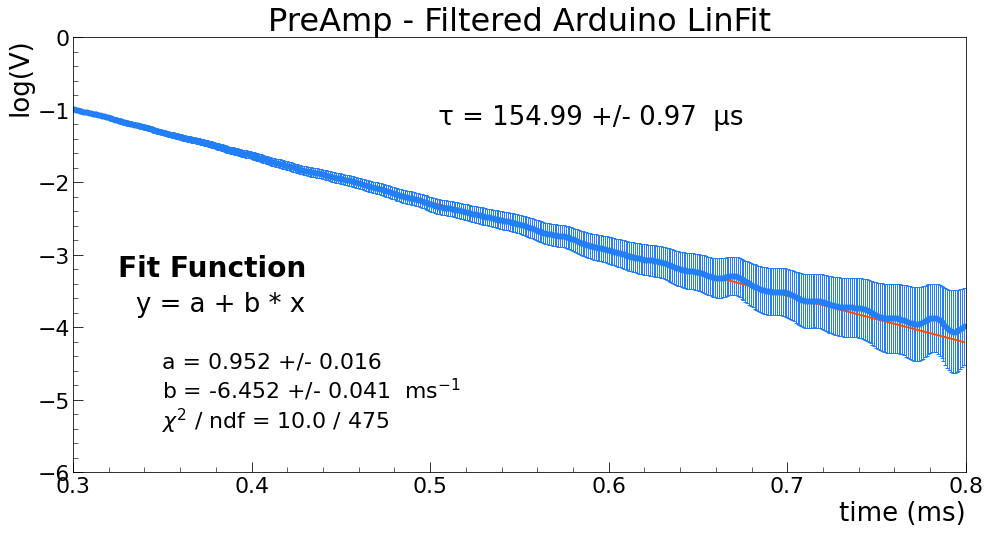

In [646]:
NR.arduino_butter_lin_fit(data_peek_butter)

In [645]:
importlib.reload(NR)

<module 'Arduino_NoiseReduction_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\Arduino_NoiseReduction_Code.py'>

## Moving Average

In [651]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = arduino_calib_offset + arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(arduino_calib_offset_err**2 + arduino_calib_slope_err**2)

# PRINT DATA
data

,time,ADC,time (ms),V (V),err V (V)
1,1,795,0.001047,0.021977,0.009805
2,2,793,0.002094,0.020320,0.009805
3,3,793,0.003141,0.020320,0.009805
4,4,798,0.004188,0.024462,0.009805
5,5,795,0.005236,0.021977,0.009805
...,...,...,...,...,...
2043,2043,793,2.139267,0.020320,0.009805
2044,2044,776,2.140314,0.006239,0.009805
2045,2045,787,2.141361,0.015350,0.009805
2046,2046,788,2.142408,0.016178,0.009805


In [652]:
# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

# WINDOW
WND = 10

# TAKE THE MOVING AVERAGE
data_peek['AVG'] = data_peek['V (V)'].rolling(window=WND).mean()

# COMPUTER MEAN ERROR
data_peek['err AVG'] = data_peek['err V (V)'] / np.sqrt(2*WND+1)

# DROP NAN ROWS
data_peek = data_peek[data_peek['AVG'].notna()]

# PRINT DATA
data_peek

,time,ADC,time (ms),V (V),err V (V),AVG,err AVG
296,296,1211,0.309948,0.366559,0.009805,0.377658,0.00214
297,297,1210,0.310995,0.365730,0.009805,0.375422,0.00214
298,298,1208,0.312042,0.364074,0.009805,0.373351,0.00214
299,299,1206,0.313089,0.362417,0.009805,0.371280,0.00214
300,300,1204,0.314136,0.360760,0.009805,0.369044,0.00214
...,...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.014853,0.00214
1196,1196,789,1.252356,0.017007,0.009805,0.014687,0.00214
1197,1197,790,1.253403,0.017835,0.009805,0.014687,0.00214
1198,1198,789,1.254450,0.017007,0.009805,0.014439,0.00214


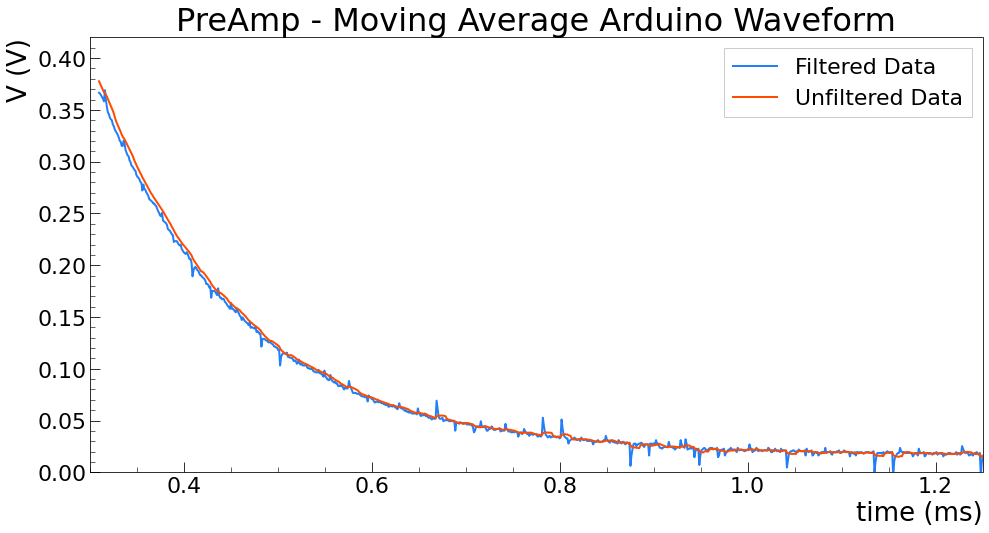

In [544]:
# FIG SETTINGS AND AXES
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(data_peek['time (ms)'], data_peek['V (V)'], color = '#227FF7', linewidth = 2, marker = '.', markersize = 0, label = 'Filtered Data')
ax1.plot(data_peek['time (ms)'], data_peek['AVG'], color = '#FF4B00', linewidth = 2, marker = '.', markersize = 0, label = 'Unfiltered Data')

# PLOT TITLE
ax1.set_title('PreAmp - Moving Average Arduino Waveform', fontsize = 32)
# AXIS LABELS
ax1.set_xlabel('time (ms)', fontsize = 26, loc = 'right')
ax1.set_ylabel('V (V)', fontsize = 26, loc = 'top')
# AXIS TICKS
ax1.tick_params(axis = 'both', which = 'major', labelsize = 22, direction = 'in', length = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 22, direction = 'in', length = 5)
ax1.set_xticks(ticks = ax1.get_xticks(), minor = True)
ax1.set_yticks(ticks = ax1.get_yticks(), minor = True)
ax1.minorticks_on()
# PLOT RANGE
ax1.set_xlim(left = 0.3, right = 1.25)
ax1.set_ylim(bottom = 0, top = 0.42)
ax1.legend(loc = 'upper right', prop = {'size': 22}, ncol = 1, frameon = True, fancybox = False, framealpha = 1)

plt.show()

In [653]:
# Normalize data by subtracting the exponential fit offset a 
data_peek['normV'] = data_peek['AVG'] - NR.unfiltered_exp_offset

# Drop all negative values
data_peek = data_peek[(data_peek['normV'] > 0)]

# Error propagation on the difference
data_peek['err normV'] = np.sqrt(data_peek['err AVG']**2 + NR.unfiltered_exp_offset_err**2)

# Take the natural logarithm 
data_peek['logV'] = np.log(data_peek['normV'])

# Error propagation on the logarithm
data_peek['err logV'] = data_peek['err normV'] / data_peek['normV']

# Drop data with huge uncertainty as it is not significative 
data_peek = data_peek[(data_peek['err logV'] < 0.5)] 
data_peek = data_peek[(data_peek['time (ms)'] < 0.8)] 
data_peek

,time,ADC,time (ms),V (V),err V (V),AVG,err AVG,normV,err normV,logV,err logV
296,296,1211,0.309948,0.366559,0.009805,0.377658,0.00214,0.360245,0.002205,-1.020972,0.006121
297,297,1210,0.310995,0.365730,0.009805,0.375422,0.00214,0.358008,0.002205,-1.027199,0.006159
298,298,1208,0.312042,0.364074,0.009805,0.373351,0.00214,0.355937,0.002205,-1.033001,0.006195
299,299,1206,0.313089,0.362417,0.009805,0.371280,0.00214,0.353867,0.002205,-1.038835,0.006232
300,300,1204,0.314136,0.360760,0.009805,0.369044,0.00214,0.351630,0.002205,-1.045176,0.006271
...,...,...,...,...,...,...,...,...,...,...,...
759,759,810,0.794764,0.034401,0.009805,0.034567,0.00214,0.017154,0.002205,-4.065547,0.128553
760,760,810,0.795812,0.034401,0.009805,0.034401,0.00214,0.016988,0.002205,-4.075252,0.129807
761,761,809,0.796859,0.033573,0.009805,0.034236,0.00214,0.016822,0.002205,-4.085052,0.131085
762,762,810,0.797906,0.034401,0.009805,0.034319,0.00214,0.016905,0.002205,-4.080140,0.130443


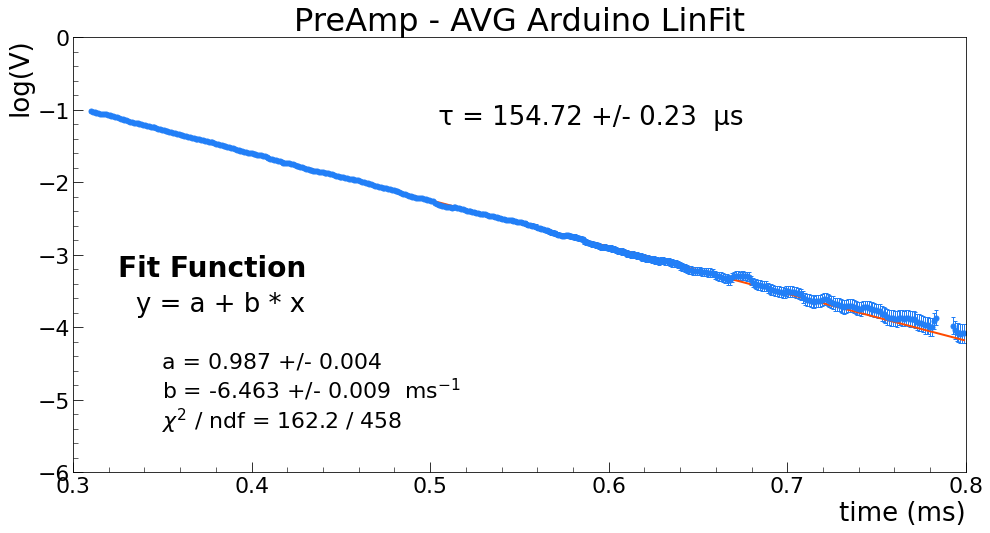

In [654]:
# FIG SETTINGS AND AXES
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 1, 1)

# PERFORM THE FIT
par, cov = curve_fit(f = lin, xdata = data_peek['time (ms)'], ydata = data_peek['logV'], sigma = data_peek['err logV'], absolute_sigma=True)
func = lin(data_peek['time (ms)'], *par)

data_peek = data_peek[((data_peek['logV'] - func) / data_peek['err logV']) < 2]

# PERFORM THE FIT
par, cov = curve_fit(f = lin, xdata = data_peek['time (ms)'], ydata = data_peek['logV'], sigma = data_peek['err logV'], absolute_sigma=True)
func = lin(data_peek['time (ms)'], *par)

# COMPUTE RESIDUALS
res = data_peek['logV'] - func

# COMPUTE CHI2
chi2 = np.sum((res/data_peek['err logV'])**2)

# GET FIT PARAMETERS AND PARAMETER ERRORS
error = []
for i in range(len(par)):
    try:
        error.append(np.absolute(cov[i][i])**0.5)
    except:
        error.append( 0.00 )
fit_par = par
fit_err = np.array(error)
a = fit_par[0]
b = fit_par[1]
err_a = fit_err[0]
err_b = fit_err[1]

# PLOT DATA
ax1.errorbar(data_peek['time (ms)'], data_peek['logV'], xerr = 0, yerr = data_peek['err logV'], elinewidth=1, 
            capsize=2, color = '#227FF7', linewidth = 0, marker = '.', markersize = 10, label = 'data_peek')
ax1.plot(data_peek['time (ms)'], func, color = '#FF4B00', linewidth = 2, label = 'Fit')

aa = 'a = ' + format(a, '1.3f') + ' +/- ' + format(err_a, '1.3f')
bb = 'b = ' + format(b, '1.3f') + ' +/- ' + format(err_b, '1.3f') + '  ms$^{-1}$'
tau = ' \u03C4 = ' + format(-b**-1 * 1e3, '1.2f') + ' +/- ' + format(err_b * b**-2 * 1e3, '1.2f') + '  \u03BCs'
chisq = '$\chi^{2}$ / ndf = ' + format(chi2, '1.1f') + ' / ' + format(len(data_peek['time (ms)'] ) - len(par), '1.0f')

ax1.text(0.05, 0.45, 'Fit Function', fontsize = 28, fontweight = 'bold', transform=ax1.transAxes)
ax1.text(0.07, 0.37, 'y = a + b * x', fontsize = 26, color = '#000000', transform = ax1.transAxes)
ax1.text(0.1, 0.1, aa + '\n' + bb + '\n' + chisq, fontsize = 22, color = '#000000', transform = ax1.transAxes)
ax1.text(0.4, 0.8, tau, fontsize = 26, color = '#000000', transform = ax1.transAxes)

# PLOT TITLE
ax1.set_title('PreAmp - AVG Arduino LinFit', fontsize = 32)

# AXIS LABELS
ax1.set_xlabel('time (ms)', fontsize = 26, loc = 'right')
ax1.set_ylabel('log(V)', fontsize = 26, loc = 'top')

# AXIS TICKS
ax1.tick_params(axis = 'both', which = 'major', labelsize = 22, direction = 'in', length = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 22, direction = 'in', length = 5)
ax1.set_xticks(ticks = ax1.get_xticks(), minor = True)
ax1.set_yticks(ticks = ax1.get_yticks(), minor = True)
ax1.minorticks_on()

# PLOT RANGE
ax1.set_xlim(left = 0.30, right = 0.8)
ax1.set_ylim(bottom = -6, top = 0)

# SAVE FIGURE
#fig.savefig('../Plots/Arduino_NR/preamp_butter_linfit.png', dpi = 300, facecolor = 'white')

plt.show()